# Import Libraries

In [1]:
data_name = 'driveaer'
data_dir = 'data_prep_transformer'

In [2]:

# import bpy
import os
import re
# import mathutils
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
import pyvista as pv
from scipy.interpolate import griddata
import multiprocessing as mp


STEPS:
1. Load STL/VTK geometry
2. ADD scalar to mesh if STL else use VTK and Save as VTK
3. Save surface mesh with scalar we want to use
4. Remove outliers
5. GET global normalization params
6. Normalize both geometry and scalar
7. Save Normalzied VTK file

# Step1 : Load STL/VTK files

In [4]:
import os
import re

load_dir = f'/raid/ansysai/udbhav/alpha_Xdata/raw_data/{data_name}/'
# load_dir = f'/tmp/xgm_data/raw_data/{data_name}'
geometry_data = []

# Loop through each subfolder in the main directory
for subfolder in os.listdir(load_dir):
    subfolder_path = os.path.join(load_dir, subfolder)
    if os.path.isdir(subfolder_path):
        # Collect all .vtk files in the subfolder
        vtk_files = [
            os.path.join(subfolder_path, x)
            for x in os.listdir(subfolder_path) if x.endswith('.vtk')
        ]
        geometry_data.extend(vtk_files)

# Sort all files based on the numeric part of the filename
geometry_data = sorted(
    geometry_data,
    key=lambda x: int(re.search(r'(\d+)', os.path.splitext(os.path.basename(x))[0]).group(0))
)

print(len(geometry_data))
print(geometry_data[:5])

400
['/raid/ansysai/udbhav/alpha_Xdata/raw_data/driveaer/driveaer_1/DrivAer_F_D_WM_WW_0001.vtk', '/raid/ansysai/udbhav/alpha_Xdata/raw_data/driveaer/driveaer_2/DrivAer_F_D_WM_WW_0002.vtk', '/raid/ansysai/udbhav/alpha_Xdata/raw_data/driveaer/driveaer_3/DrivAer_F_D_WM_WW_0003.vtk', '/raid/ansysai/udbhav/alpha_Xdata/raw_data/driveaer/driveaer_4/DrivAer_F_D_WM_WW_0004.vtk', '/raid/ansysai/udbhav/alpha_Xdata/raw_data/driveaer/driveaer_5/DrivAer_F_D_WM_WW_0005.vtk']


# STEP 3: rename scalar name if incorrect

In [5]:
save_dir = f'/home/alpha_Xdata/xgm_data/{data_dir}/1_Incompressible_external_flow/{data_name}/1_VTK_surface'
os.makedirs(save_dir, exist_ok=True)

PermissionError: [Errno 13] Permission denied: '/home/alpha_Xdata'

In [ ]:


def map_conditions_to_mesh_points(mesh,**fluid_props ):
    # compute scale
    scale = [(mesh.points[:,0].max() - mesh.points[:,0].min()) , (mesh.points[:,1].max() - mesh.points[:,1].min()) , (mesh.points[:,2].max() - mesh.points[:,2].min())]


    field_data = {
        "fluid_density": fluid_props.get("fluid_density", 1.184),
        "inlet_velocity": fluid_props.get("inlet_velocity", 30.0),
        "viscosity_dynamic": fluid_props.get("viscosity_dynamic", 1.847e-5),
        'scale_x':           scale[0],
        'scale_y':           scale[1],
        'scale_z':           scale[2],
        "problem_type": fluid_props.get("problem_type", 1)
    }


    return field_data


In [ ]:

def process_single_geometry(args):
    global_idx, stl_path, save_dir = args
    try:
        mesh = pv.read(stl_path)
        surf = mesh.extract_surface()

        surf.point_data["pressure"] = surf["p"]

        
        out_dir = os.path.join(save_dir, f"{data_name}_{global_idx}")
        os.makedirs(out_dir, exist_ok=True)

        field_data = map_conditions_to_mesh_points(surf)
        for k, v in field_data.items():
            surf.field_data[k] = np.array([v])

        vtk_file = os.path.join(out_dir, f"{data_name}_{global_idx}.vtp")
        surf.save(vtk_file)


    except Exception as e:
        print(f"[ERROR] global_idx={global_idx} failed on {stl_path} : {e}")

# ----------- Build args_list with global_idx for each condition -----------
args_list = []
global_idx = 0

for idx in range(len(geometry_data)):    
    args_list.append((global_idx, geometry_data[idx], save_dir))
    global_idx += 1

# ----------- Run in parallel -----------
with mp.Pool(processes=50) as pool:
    list(tqdm(pool.imap_unordered(process_single_geometry, args_list), total=len(args_list)))


100%|██████████| 400/400 [00:22<00:00, 17.49it/s]


# Clip data 

In [ ]:
load_dir_surface1 = f'/raid/ansysai/udbhav//alpha_Xdata/xgm_data/{data_dir}/1_Incompressible_external_flow/{data_name}/1_VTK_surface/'

# Get sorted list of subdirectories like "artery_0", "artery_1", etc.
subfolders_1 = sorted(
    [f for f in os.listdir(load_dir_surface1) if os.path.isdir(os.path.join(load_dir_surface1, f))],
    key=lambda x: int(x.split('_')[1])  # sort numerically by index
)

# Build full paths to each .vtk file inside those folders
vtk_surface_files = [
    os.path.join(load_dir_surface1, folder, f'{folder}.vtp')  # e.g. /.../artery_0/artery_0.vtk
    for folder in subfolders_1
]

# Get sorted list of subdirectories like "artery_0", "artery_1", etc.
print(len(vtk_surface_files))

400


In [ ]:
def load_pressure_scalar(file_path):
    try:
        mesh = pv.read(file_path)
        return mesh['pressure']
    except Exception as e:
        print(f"[ERROR] Failed to read pressure from {file_path}: {e}")
        return None

def load_points(file_path):
    try:
        mesh = pv.read(file_path)
        return mesh.points
    except Exception as e:
        print(f"[ERROR] Failed to read points from {file_path}: {e}")
        return None

# Step 1: Load all pressure values and coordinates in parallel
with mp.Pool(processes=50) as pool:
    all_pressure = list(tqdm(pool.imap(load_pressure_scalar, vtk_surface_files), total=len(vtk_surface_files)))
    all_coordinates = list(tqdm(pool.imap(load_points, vtk_surface_files), total=len(vtk_surface_files)))
    # Convert to float64 and concatenate
    all_coordinates = [arr.astype(np.float64) for arr in all_coordinates if arr is not None]
    all_coordinates = np.vstack(all_coordinates)
    print("all_coordinates dtype:", all_coordinates.dtype)
    print("min coords (float64):", all_coordinates.min(axis=0))
    print("max coords (float64):", all_coordinates.max(axis=0))

# Step 2: Filter out None (failed loads), and concatenate
all_pressure = [arr for arr in all_pressure if arr is not None]
all_pressure = np.concatenate(all_pressure)
all_coordinates = [arr for arr in all_coordinates if arr is not None]
all_coordinates = np.vstack(all_coordinates)


100%|██████████| 400/400 [00:04<00:00, 98.47it/s] 


all_coordinates dtype: float64
min coords (float64): [-1.14437997 -1.02134001  0.        ]
max coords (float64): [4.08646011 1.02122998 1.75308001]


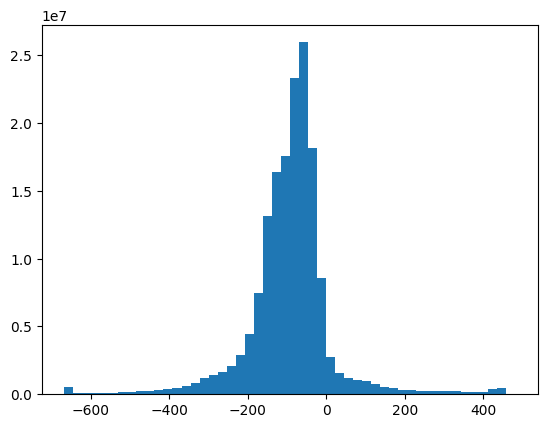

-667.9592 480.74426
-93.194176 111.9078
(161664241, 3)
[-1.14438 -1.02134  0.     ] [4.08646 1.02123 1.75308]


In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_pressure, bins=50)
plt.show()
print(all_pressure.min(), all_pressure.max())
print(all_pressure.mean(), all_pressure.std())  
print(all_coordinates.shape)
print(all_coordinates.min(axis=0), all_coordinates.max(axis=0))

In [ ]:
mu = np.nanmean(all_pressure)          # use mean that ignores NaNs
sigma = np.nanstd(all_pressure)        # std that ignores NaNs

lower, upper = mu - 5*sigma, mu + 5*sigma

clipped_mask = ((all_pressure < lower) | (all_pressure > upper))
num_clipped = int(np.count_nonzero(clipped_mask))
print(f"Clipped {num_clipped} values ({num_clipped/all_pressure.size:.2%}) "
      f"to [{lower:.6g}, {upper:.6g}] ")

all_pressure_clipped = np.clip(all_pressure, lower, upper)  # in-place clip (no extra allocation)



Clipped 484353 values (0.30%) to [-652.733, 466.345] 


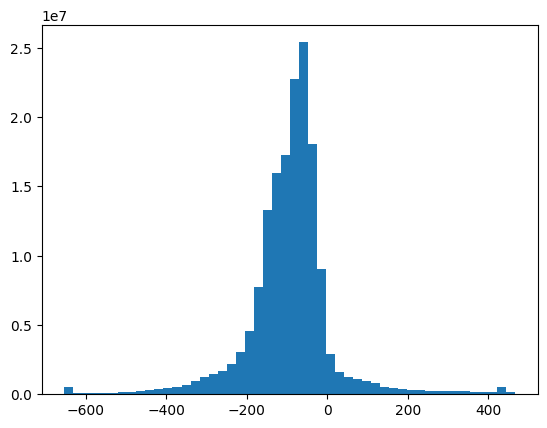

-652.73315 466.34482
-93.15071 111.687256


In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_pressure_clipped, bins=50)
plt.show()
print(all_pressure_clipped.min(), all_pressure_clipped.max())
print(all_pressure_clipped.mean(), all_pressure_clipped.std())

In [ ]:
all_pressure_clipped.mean()
all_pressure_clipped.std()
vtk_surface_files

['/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_0/driveaer_0.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_1/driveaer_1.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_2/driveaer_2.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_3/driveaer_3.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_4/driveaer_4.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer/1_VTK_surface/driveaer_5/driveaer_5.vtp',
 '/raid/ansysai/udbhav//alpha_Xdata/xgm_data/data_prep_transformer/1_Incompressible_external_flow/driveaer

In [ ]:
# # Choose tails (percent)
# p_low, p_high = 0.1, 99.9   # <- use 99 if you meant 99th percentile

# # Compute percentiles on finite values only (ignores NaNs/±inf)

# lower, upper = np.percentile(all_pressure, [p_low, p_high])

# # Report how many would be clipped
# clipped_mask = ((all_pressure < lower) | (all_pressure > upper))
# num_clipped = int(np.count_nonzero(clipped_mask))
# print(f"Clipped {num_clipped} values ({num_clipped/all_pressure.size:.2%}) "
#       f"to [{lower:.6g}, {upper:.6g}] using percentiles [{p_low}%, {p_high}%].")

# # In-place clip
# all_pressure_clipped = np.clip(all_pressure, lower, upper)
# print(lower, upper)

In [ ]:

def process_single_geometry(args):
    global_idx, stl_path, save_dir = args
    try:
        mesh = pv.read(stl_path)
        mesh['pressure'] = np.clip(mesh['pressure'], lower, upper)

        
        out_dir = os.path.join(save_dir, f"{data_name}_{global_idx}")
        os.makedirs(out_dir, exist_ok=True)

        vtk_file = os.path.join(out_dir, f"{data_name}_{global_idx}.vtp")
        mesh.save(vtk_file)


    except Exception as e:
        print(f"[ERROR] global_idx={global_idx} failed on {stl_path} : {e}")

# ----------- Build args_list with global_idx for each condition -----------
args_list = []
global_idx = 0

for idx in range(len(vtk_surface_files)):    
    args_list.append((global_idx, vtk_surface_files[idx], save_dir))
    global_idx += 1

# ----------- Run in parallel -----------
with mp.Pool(processes=50) as pool:
    list(tqdm(pool.imap_unordered(process_single_geometry, args_list), total=len(args_list)))


100%|██████████| 400/400 [00:23<00:00, 17.20it/s]


# Test plot

In [ ]:
import pyvista as pv
pv.start_xvfb()

data_name = 'driveaer'
data_dir = 'data_prep_full_v2'
sample_num = 10

/usr/local/lib/python3.9/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


1. PLOT GT VTK

In [ ]:

meshgt = pv.read(f'/home/alpha_Xdata/xgm_data/{data_dir}/1_Incompressible_external_flow/{data_name}/1_VTK_surface/{data_name}_{sample_num}/{data_name}_{sample_num}.vtp')
meshgt

PolyData (0x7f268b8ef5e0)
  N Cells:    366890
  N Points:   399125
  N Strips:   0
  X Bounds:   -9.892e-01, 3.968e+00
  Y Bounds:   -1.019e+00, 1.019e+00
  Z Bounds:   0.000e+00, 1.451e+00
  N Arrays:   11

/usr/local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame.app'

Falling back to a static output.
  warnings.warn(


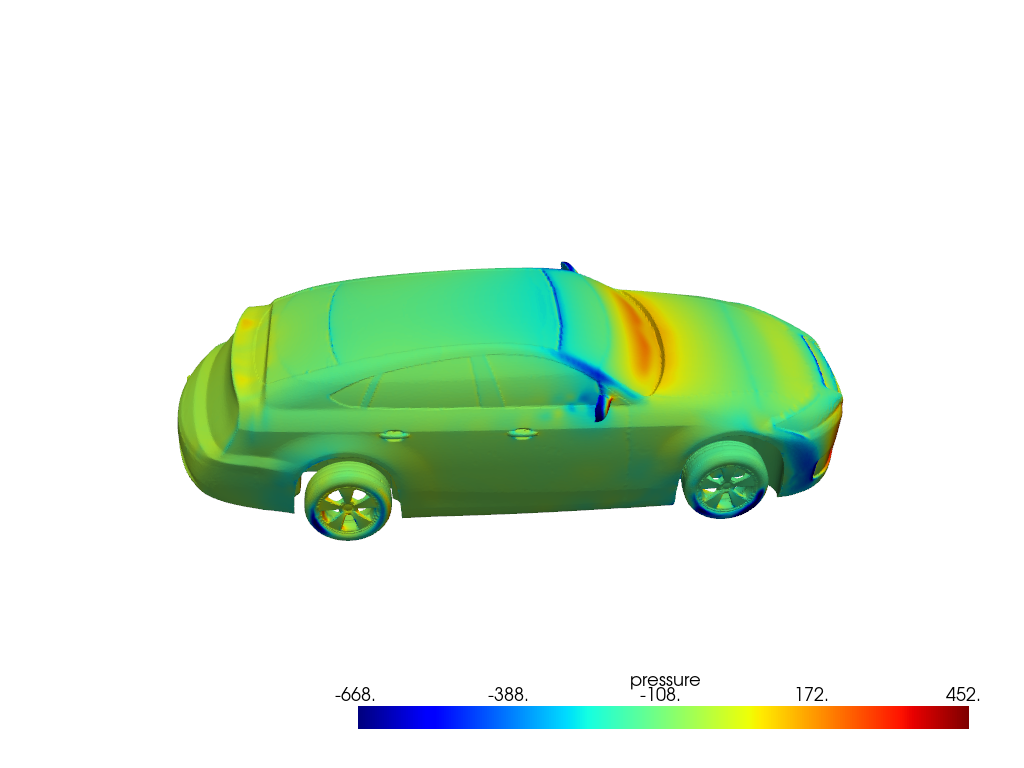

In [ ]:
plotter = pv.Plotter()
plotter.add_mesh(meshgt, scalars='pressure', cmap='jet')

plotter.camera.azimuth = 40
plotter.show()

In [9]:
import re

file_list = [
    'dr/iveaer_396.vtp', 'driveaer_397.vtp', 'driveaer_398.vtp', 'driveaer_399.vtp', 'driveaer_4.vtp',
    'driveaer_40.vtp', 'driveaer_41.vtp', 'driveaer_42.vtp', 'driveaer_43.vtp', 'driveaer_44.vtp',
    'driveaer_45.vtp', 'driveaer_46.vtp', 'driveaer_47.vtp', 'driveaer_48.vtp', 'driveaer_49.vtp',
    'driveaer_5.vtp', 'driveaer_50.vtp', 'driveaer_51.vtp', 'driveaer_52.vtp', 'driveaer_53.vtp',
    'driveaer_54.vtp', 'driveaer_55.vtp', 'driveaer_56.vtp', 'driveaer_57.vtp', 'driveaer_58.vtp',
    'driveaer_59.vtp', 'driveaer_6.vtp', 'driveaer_60.vtp', 'driveaer_61.vtp', 'driveaer_62.vtp',
    'driveaer_63.vtp', 'driveaer_64.vtp', 'driveaer_65.vtp', 'driveaer_66.vtp', 'driveaer_67.vtp',
    'driveaer_68.vtp', 'driveaer_69.vtp', 'driveaer_7.vtp', 'driveaer_70.vtp', 'driveaer_71.vtp',
    'driveaer_72.vtp', 'driveaer_73.vtp', 'driveaer_74.vtp', 'driveaer_75.vtp', 'driveaer_76.vtp',
    'driveaer_77.vtp', 'driveaer_78.vtp', 'driveaer_79.vtp', 'driveaer_8.vtp', 'driveaer_80.vtp',
    'driveaer_81.vtp', 'driveaer_82.vtp', 'driveaer_83.vtp', 'driveaer_84.vtp', 'driveaer_85.vtp',
    'driveaer_86.vtp', 'driveaer_87.vtp', 'driveaer_88.vtp', 'driveaer_89.vtp', 'driveaer_9.vtp',
    'driveaer_90.vtp', 'driveaer_91.vtp', 'driveaer_92.vtp', 'driveaer_93.vtp', 'driveaer_94.vtp',
    'driveaer_95.vtp', 'driveaer_96.vtp', 'driveaer_97.vtp', 'driveaer_98.vtp', 'driveaer_99.vtp'
]

# Extract the integer after 'driveaer_' and before '.vtp'
# Only extract numbers from files that match the pattern
int_list = []
for f in file_list:
    m = re.search(r'driveaer_(\d+)\.vtp', f)
    if m:
        int_list.append(int(m.group(1)))
    else:
        print(f"Pattern not matched: {f}")

int_list = (int_list)
print(int_list)


Pattern not matched: dr/iveaer_396.vtp
[397, 398, 399, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
